In [12]:
import matplotlib.pyplot as plt
from gerrychain import (Partition, Graph, MarkovChain,
                        updaters, constraints, accept,
                        GeographicPartition)
from gerrychain.proposals import recom
from gerrychain.tree import bipartition_tree
from gerrychain.constraints import contiguous
from functools import partial
import pandas
import geopandas as gpd

# Set the random seed so that the results are reproducible!
import random
random.seed(42)

In [13]:
gdf = gpd.read_file("../data/MN_precincts.geojson")
# gdf = gpd.read_file("../data/TX_vtds/TX_VTDs.geojson")
# gdf['geometry'] = gdf['geometry'].buffer(0)

# print("Current CRS:", gdf.crs)
# gdf = gdf.to_crs(epsg=32617)
# print("New CRS:", gdf.crs)

gdf.columns

Index(['VTDID', 'PCTNAME', 'PCTCODE', 'MCDNAME', 'MCDCODE', 'CTU_TYPE',
       'COUNTYNAME', 'COUNTYFIPS', 'CONGDIST', 'MNSENDIST', 'MNLEGDIST',
       'CTYCOMDIST', 'JUDDIST', 'TOTVOT16', 'PRES16R', 'PRES16D', 'PRES16G',
       'PRES16I', 'PRES16L', 'USH16R', 'USH16D', 'SSEN16R', 'SSEN16D', 'SH16R',
       'SH16D', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')

In [14]:
graph = Graph.from_geodataframe(gdf)

In [15]:
my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": updaters.cut_edges,
    "perimeter": updaters.perimeter,
    "area": updaters.Tally("area", alias="area"),
    "geometry": updaters.boundary_nodes,
}

initial_partition = GeographicPartition(
    graph,
    assignment="MNSENDIST",
    # assignment="USCD",
    updaters=my_updaters
)


{4096, 1026, 1027, 1033, 1037, 1039, 1040, 1049, 1051, 1053, 1063, 1068, 1083, 4012, 1099, 1611, 2125, 1102, 1615, 1616, 1618, 2132, 1621, 599, 1111, 1625, 1114, 2139, 3783, 605, 1118, 1631, 1633, 1122, 1634, 614, 616, 619, 620, 1133, 2159, 3187, 3188, 3788, 1145, 1146, 1147, 3193, 637, 1151, 3203, 1156, 3205, 646, 3206, 1160, 649, 650, 2185, 652, 653, 654, 2698, 3217, 2707, 660, 661, 662, 2709, 2201, 2202, 667, 3226, 3227, 670, 2211, 2212, 2724, 2725, 2727, 3235, 3236, 3238, 2731, 2734, 3758, 3763, 3764, 3766, 2746, 3770, 2748, 3776, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 2763, 2765, 3279, 3281, 3282, 2775, 3283, 3288, 3795, 3796, 3799, 3293, 3294, 3803, 3804, 3297, 3298, 2787, 3299, 2789, 2790, 3301, 2793, 3306, 3307, 3308, 3312, 3313, 3314, 3315, 2806, 1788, 1789, 2812, 1791, 2814, 1793, 1794, 2815, 3857, 2322, 2834, 3862, 2844, 2845, 3358, 3876, 2342, 2343, 2344, 2345, 2348, 3892, 3893, 3894, 3899, 324, 325, 3909, 329, 1869, 1870, 3917, 3408, 337, 338, 339

<Axes: title={'center': 'Initial Partition in MN'}>

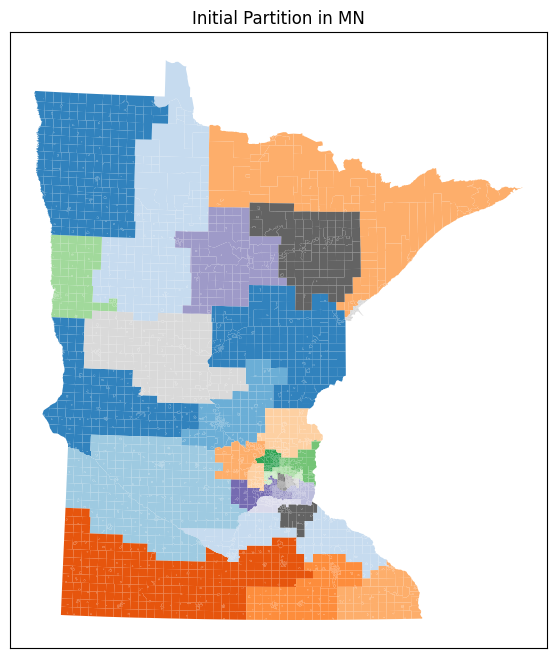

In [16]:
print(initial_partition.geometry)
fig, ax = plt.subplots(figsize=(8,8))
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Initial Partition in MN")
initial_partition.plot(ax=ax, cmap='tab20c')

In [51]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)


proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.01,
    node_repeats=2,
)

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=2,
)

In [52]:
print(recom_chain)

for i, partition in enumerate(recom_chain):
    print(i, partition)

<MarkovChain [2 steps]>
0 <GeographicPartition [67 parts]>
1 <GeographicPartition [67 parts]>


In [53]:
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

import pandas as pd

import matplotlib.cm as mcm
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

frames = []
district_data = []


for i, partition in enumerate(recom_chain):


    gdf['plan_{}'.format(i)] = [partition.assignment[n] for n in graph.nodes] #store plan


    for district_name in partition.perimeter.keys():
        population = partition.population[district_name]
        perimeter = partition.perimeter[district_name]
        area = partition.area[district_name]
        exterior_boundaries = partition.exterior_boundaries[district_name]
        interior_boundaries = partition.interior_boundaries[district_name]
        # boundry_nodes = partition.boundry_nodes[district_name]
        # cut_edges = partition.cut_edges[district_name]
        cut_edges_by_part = partition.cut_edges_by_part[district_name]
        district_data.append((i, district_name, population, perimeter, area, exterior_boundaries, interior_boundaries, cut_edges_by_part))

    buffer = io.BytesIO()
    fig, ax = plt.subplots(figsize=(10,10))
    partition.plot(ax=ax, cmap='tab20')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(buffer, format='png', bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    frames.append(image)
    plt.close(fig)

df = pd.DataFrame(
    district_data,
    columns=[
        'step',
        'district_name',
        'population',
        'perimeter',
        'area',
        'exterior_boundaries',
        'interior_boundaries',
        'cut_edges_by_part'
    ]
)

def show_frame(idx):
    clear_output(wait=True)
    display(frames[idx])

slider = widgets.IntSlider(value=0, min=0, max=len(frames)-1, step=1, description='Frame:')
slider.layout.width = '500px'
widgets.interactive(show_frame, idx=slider)

interactive(children=(IntSlider(value=0, description='Frame:', layout=Layout(width='500px'), max=1), Output())…

In [20]:
gdf.columns
df.columns

Index(['VTDID', 'PCTNAME', 'PCTCODE', 'MCDNAME', 'MCDCODE', 'CTU_TYPE',
       'COUNTYNAME', 'COUNTYFIPS', 'CONGDIST', 'MNSENDIST', 'MNLEGDIST',
       'CTYCOMDIST', 'JUDDIST', 'TOTVOT16', 'PRES16R', 'PRES16D', 'PRES16G',
       'PRES16I', 'PRES16L', 'USH16R', 'USH16D', 'SSEN16R', 'SSEN16D', 'SH16R',
       'SH16D', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry', 'plan_0', 'plan_1', 'plan_2', 'plan_3',
       'plan_4', 'plan_5', 'plan_6', 'plan_7', 'plan_8', 'plan_9', 'plan_10',
       'plan_11', 'plan_12', 'plan_13', 'plan_14', 'plan_15', 'plan_16',
       'plan_17', 'plan_18', 'plan_19'],
      dtype='object')

In [21]:

import geopandas as gpd

gdf = gpd.read_file('proposals/MN_VTDs_with_recom.geojson')
dissolved = gdf.dissolve(by='plan_17')
dissolved.to_file('test_join.geojson', driver='GeoJSON')


In [22]:
dissolved

,geometry,VTDID,PCTNAME,PCTCODE,MCDNAME,MCDCODE,CTU_TYPE,COUNTYNAME,COUNTYFIPS,CONGDIST,...,plan_9,plan_10,plan_11,plan_12,plan_13,plan_14,plan_15,plan_16,plan_18,plan_19
plan_17,,,,,,,,,,,,,,,,,,,,,
1,"POLYGON ((300443.909 5138309.641, 298810.140 5...",270050035,Carsonville Twp,0035,Carsonville Twp,035,township,Becker,005,7,...,1,1,1,1,1,1,1,1,1,1
10,"POLYGON ((393938.860 5112761.640, 393986.920 5...",270010005,Aitkin,0005,Aitkin,004,city,Aitkin,001,8,...,10,10,10,10,10,10,10,10,10,10
11,"POLYGON ((480529.049 5064163.650, 479305.280 5...",270170005,Atkinson Twp,0005,Atkinson Twp,005,township,Carlton,017,8,...,11,11,11,11,11,11,11,11,11,11
12,"POLYGON ((229274.991 5022160.191, 229272.276 5...",270050005,Atlanta Twp,0005,Atlanta Twp,005,township,Becker,005,7,...,1,12,12,12,12,12,12,12,4,4
13,"POLYGON ((375552.740 5020347.380, 375311.180 5...",270090056,Minden Twp P-2,0056,Minden Twp,050,township,Benton,009,6,...,13,13,13,13,13,13,13,13,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,"POLYGON ((488433.185 4979052.620, 488433.028 4...",271230060,Falcon Heights P-1,0060,Falcon Heights,030,city,Ramsey,123,4,...,66,66,66,66,66,66,66,66,66,66
67,"POLYGON ((496778.859 4977188.398, 496781.845 4...",271230240,Maplewood P-12,0240,Maplewood,070,city,Ramsey,123,4,...,53,53,53,53,53,53,53,67,67,67
7,"POLYGON ((559417.941 5166865.350, 559011.790 5...",271370140,Duluth P-1,0140,Duluth,125,city,St. Louis,137,8,...,7,7,7,7,7,7,7,7,7,7


<Axes: >

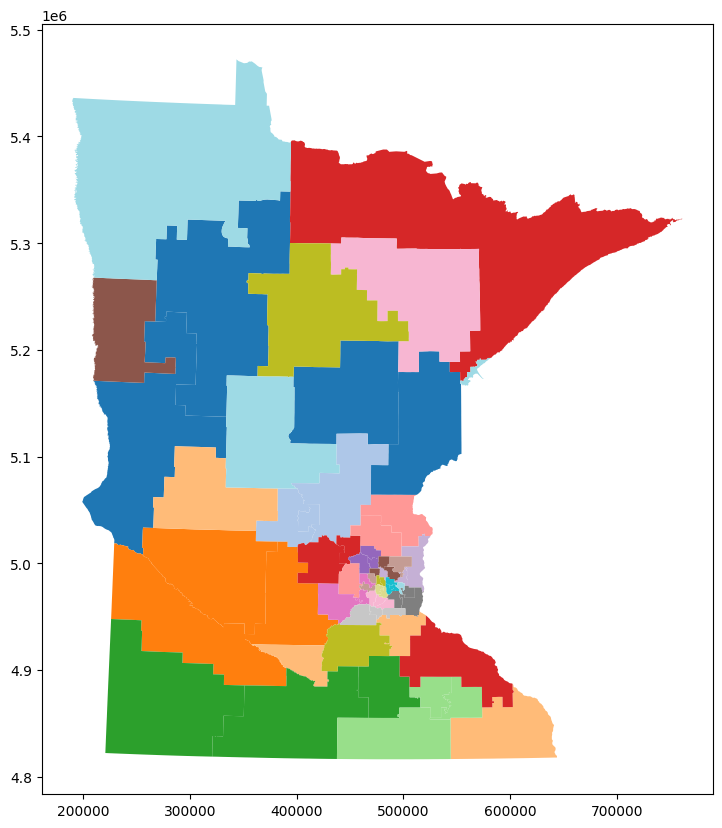

In [12]:
dissolved.plot(cmap='tab20', legend=True, figsize=(10,10))

In [29]:
print("original precinct data + plans")
print(gdf.shape)
print(gdf.columns)

print("\ndata obtained from the chain (per district)")
print(df.shape)
print(df.columns)

print("\ntransformed precinct to district (single plan) (uncleaned)")
print(dissolved.shape)
print(dissolved.columns)

original precinct data + plans
(4120, 71)
Index(['VTDID', 'PCTNAME', 'PCTCODE', 'MCDNAME', 'MCDCODE', 'CTU_TYPE',
       'COUNTYNAME', 'COUNTYFIPS', 'CONGDIST', 'MNSENDIST', 'MNLEGDIST',
       'CTYCOMDIST', 'JUDDIST', 'TOTVOT16', 'PRES16R', 'PRES16D', 'PRES16G',
       'PRES16I', 'PRES16L', 'USH16R', 'USH16D', 'SSEN16R', 'SSEN16D', 'SH16R',
       'SH16D', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'plan_0', 'plan_1', 'plan_2', 'plan_3', 'plan_4', 'plan_5',
       'plan_6', 'plan_7', 'plan_8', 'plan_9', 'plan_10', 'plan_11', 'plan_12',
       'plan_13', 'plan_14', 'plan_15', 'plan_16', 'plan_17', 'plan_18',
       'plan_19', 'geometry'],
      dtype='object')

data obtained from the chain (per district)
(1340, 8)
Index(['step', 'district_na

In [58]:
test_gdf = gdf.copy()

# select all plans and geometries
plans = test_gdf[['plan_{}'.format(i) for i in range(2)] + ['geometry']]
plans

# turn all the plans into columns
plans = plans.melt(id_vars='geometry', value_vars=['plan_{}'.format(i) for i in range(2)], var_name='plan', value_name='district')
plans

# remove the 'plan_' from the plan column
plans['plan'] = plans['plan'].str.replace('plan_', '')
plans

# for each unique plan disolve the geometries based on the plan and district (make sure that plan and districts are still columns)
dissolved = plans.dissolve(by=['plan', 'district']).reset_index()



In [60]:
dissolved = dissolved.reset_index()
dissolved


,plan,district,geometry
0,0,1,"POLYGON ((217463.799 5267418.400, 215843.721 5..."
1,0,10,"POLYGON ((393938.860 5112761.640, 393986.920 5..."
2,0,11,"POLYGON ((480529.049 5064163.650, 479305.280 5..."
3,0,12,"MULTIPOLYGON (((235575.201 5017234.269, 235546..."
4,0,13,"POLYGON ((375552.740 5020347.380, 375311.180 5..."
...,...,...,...
129,1,66,"POLYGON ((488433.185 4979052.620, 488433.028 4..."
130,1,67,"POLYGON ((498619.391 4970818.751, 498458.039 4..."
131,1,7,"POLYGON ((559417.941 5166865.350, 559011.790 5..."
132,1,8,"MULTIPOLYGON (((263509.180 5110653.521, 261909..."


In [61]:
df

,step,district_name,population,perimeter,area,exterior_boundaries,interior_boundaries,cut_edges_by_part
0,0,10,78702.0,420878.428004,8.156826e+09,0.000000,420878.428004,"{(519, 814), (47, 1804), (53, 1753), (806, 230..."
1,0,35,79047.0,64860.967475,1.722802e+08,0.000000,64860.967475,"{(67, 123), (58, 59), (163, 170), (113, 117), ..."
2,0,31,78995.0,174204.347236,1.162097e+09,0.000000,174204.347236,"{(161, 621), (58, 59), (161, 618), (1675, 1677..."
3,0,37,79243.0,47233.624910,1.009246e+08,0.000000,47233.624910,"{(119, 121), (179, 2906), (179, 3037), (78, 80..."
4,0,38,79129.0,105165.627074,2.768811e+08,0.000000,105165.627074,"{(3044, 3050), (2886, 3046), (2898, 3045), (78..."
...,...,...,...,...,...,...,...,...
129,1,64,79300.0,34740.781699,3.996084e+07,0.000000,34740.781699,"{(2981, 2982), (1379, 2984), (2942, 2947), (14..."
130,1,65,78943.0,38088.286862,3.758137e+07,0.000000,38088.286862,"{(2942, 2947), (2940, 2947), (2998, 3001), (30..."
131,1,67,79199.0,34183.535096,4.821296e+07,0.000000,34183.535096,"{(2903, 3014), (3006, 3011), (2903, 3026), (29..."
132,1,7,78936.0,131590.640846,1.719113e+08,67483.224369,64107.416478,"{(3286, 3291), (3303, 3304), (3285, 3387), (46..."


In [76]:
gdf = gpd.read_file("../data/MN_precincts.geojson")
gdf

,MNSENDIST,geometry,VTDID,PCTNAME,PCTCODE,MCDNAME,MCDCODE,CTU_TYPE,COUNTYNAME,COUNTYFIPS,...,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,TOTPOP_y,TOTVOT16_y,PRES16R_y,PRES16D_y
0,1,"POLYGON ((217463.799 5267418.400, 215843.721 5...",270690005,Arveson Twp,0005,Arveson Twp,005,township,Kittson,069,...,0.0,0.0,0.0,0.0,0.0,0.0,79235.0,38875,24128,11303
1,10,"POLYGON ((393938.860 5112761.640, 393986.920 5...",270010005,Aitkin,0005,Aitkin,004,city,Aitkin,001,...,15.0,25.0,5.0,1.0,0.0,9.0,78702.0,45464,27803,14116
2,11,"POLYGON ((480529.049 5064163.650, 479305.280 5...",270170005,Atkinson Twp,0005,Atkinson Twp,005,township,Carlton,017,...,0.0,1.0,2.0,0.0,0.0,2.0,79262.0,39379,20496,15329
3,12,"MULTIPOLYGON (((235575.201 5017234.269, 235546...",270110005,Akron Twp,0005,Akron Twp,005,township,Big Stone,011,...,0.0,0.0,0.0,0.0,0.0,0.0,79357.0,43379,27734,12117
4,13,"POLYGON ((375552.740 5020347.380, 375311.180 5...",270090056,Minden Twp P-2,0056,Minden Twp,050,township,Benton,009,...,0.0,0.0,0.0,0.0,0.0,0.0,79205.0,44682,28060,13037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,66,"POLYGON ((488433.185 4979052.620, 488433.028 4...",271230060,Falcon Heights P-1,0060,Falcon Heights,030,city,Ramsey,123,...,105.0,4.0,578.0,0.0,4.0,43.0,78875.0,40420,8208,28429
63,67,"POLYGON ((498619.391 4970818.751, 498458.039 4...",271230770,Saint Paul W-2 P-10,0770,St. Paul,140,city,Ramsey,123,...,83.0,4.0,4.0,3.0,0.0,2.0,79199.0,30955,6654,21588
64,7,"POLYGON ((559417.941 5166865.350, 559011.790 5...",271370140,Duluth P-1,0140,Duluth,125,city,St. Louis,137,...,11.0,5.0,18.0,0.0,1.0,22.0,78936.0,44537,13238,26530
65,8,"MULTIPOLYGON (((263509.180 5110653.521, 261909...",270410007,Alexandria W-1 P-2,0007,Alexandria,005,city,Douglas,041,...,0.0,7.0,6.0,0.0,0.0,3.0,79318.0,46071,29171,13312


In [82]:
gdf_cpy = gdf.copy()
print(gdf_cpy.shape)
print(gdf_cpy.columns)
# select all pres16 columns, totpop, and MNSENDIST
gdf_cpy = gdf_cpy[['geometry', 'TOTPOP', 'MNSENDIST', 'TOTVOT16', 'PRES16R', 'PRES16D']]
gdf_cpy

# 1. Join polygons based on MNSENDIST to create larger polygons
joined_gdf = gdf_cpy.dissolve(by='MNSENDIST')

# 2. Tally the TOTPOP, TOTVOT16, PRES16R, and PRES16D by MNSENDIST
agg_columns = ['TOTPOP', 'TOTVOT16', 'PRES16R', 'PRES16D']
summed_gdf = gdf_cpy.groupby('MNSENDIST')[agg_columns].sum().reset_index()

# drop agg_columns from the joined_gdf
joined_gdf = joined_gdf.drop(columns=agg_columns)

# Merge the dissolved geometries with the aggregated data
result_gdf = joined_gdf.merge(summed_gdf, on='MNSENDIST')
result_gdf


# save the result to a file
# result_gdf.to_file('MN_precincts_processed.geojson', driver='GeoJSON')

(4120, 51)
Index(['VTDID', 'PCTNAME', 'PCTCODE', 'MCDNAME', 'MCDCODE', 'CTU_TYPE',
       'COUNTYNAME', 'COUNTYFIPS', 'CONGDIST', 'MNSENDIST', 'MNLEGDIST',
       'CTYCOMDIST', 'JUDDIST', 'TOTVOT16', 'PRES16R', 'PRES16D', 'PRES16G',
       'PRES16I', 'PRES16L', 'USH16R', 'USH16D', 'SSEN16R', 'SSEN16D', 'SH16R',
       'SH16D', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN',
       'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')


,MNSENDIST,geometry,TOTPOP,TOTVOT16,PRES16R,PRES16D
0,1,"POLYGON ((217463.799 5267418.400, 215843.721 5...",79235.0,38875,24128,11303
1,10,"POLYGON ((393938.860 5112761.640, 393986.920 5...",78702.0,45464,27803,14116
2,11,"POLYGON ((480529.049 5064163.650, 479305.280 5...",79262.0,39379,20496,15329
3,12,"MULTIPOLYGON (((235575.201 5017234.269, 235546...",79357.0,43379,27734,12117
4,13,"POLYGON ((375552.740 5020347.380, 375311.180 5...",79205.0,44682,28060,13037
...,...,...,...,...,...,...
62,66,"POLYGON ((488433.185 4979052.620, 488433.028 4...",78875.0,40420,8208,28429
63,67,"POLYGON ((498619.391 4970818.751, 498458.039 4...",79199.0,30955,6654,21588
64,7,"POLYGON ((559417.941 5166865.350, 559011.790 5...",78936.0,44537,13238,26530
65,8,"MULTIPOLYGON (((263509.180 5110653.521, 261909...",79318.0,46071,29171,13312
